<a href="https://colab.research.google.com/github/mdaugherity/MachineLearning2026/blob/main/tutorial/Tutorial_4_Using_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dr. Daugherity, ACU PHYS 453**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.neighbors import KNeighborsClassifier

# Tutorial 4 - Using Classifiers

**Pre-reqs:** Need the concepts from the *ML1 Theory Intro* slides.

**Goal:** Let's see how to implement the basic steps for using a classifier in scikit-learn (aka sklearn).  For now we won't worry about how the classifier actually works,  instead we will focus on the surrounding infrastructure we need to use one properly.  

We will follow the basic steps of a ML project:
1. Getting Data
1. Preprocessing
1. Training
1. Evaluating
1. Predicting


# Step 1 - Getting Data

sklearn comes with a few small standard datasets that do not require us to download files from some external website.

Name | Description
-----|------------
load_iris | Load and return the iris dataset (classification).
load_diabetes | Load and return the diabetes dataset (regression).
load_digits  | Load and return the digits dataset (classification).
load_linnerud | Load and return the linnerud dataset (multivariate regression).
load_wine | Load and return the wine dataset (classification).
load_breast_cancer | Load and return the breast cancer wisconsin dataset (classification).

The data comes in a custom format called a **bunch**.

Today we will get a subset of the iris dataset limited to 2 features and 2 targets to keep things simple.  The goal is to determine which species of iris flower we have based on a few measurements.


**References**

*   scikit-learn User's Guide: https://scikit-learn.org/stable/datasets.html
*   Iris Data: https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset
*   Iris Example: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
*   Bunch format: https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html#sklearn.utils.Bunch



In [2]:
data_bunch = datasets.load_iris()
data_bunch.keys() # see what's insde

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

We will grab what we need and throw out the rest.  As always, input features are called (capital) X and output targets are y.

In [3]:
# Note that I'm doing weird stuff to only save 2 features and 2 species
Xall = data_bunch.data
yall = data_bunch.target
X = Xall[yall>0, :2]  # drop target 0, only keep first two features
y = yall[yall>0]-1 # drop target 0 and shift remaining targets
feature_names = data_bunch.feature_names[:2]
target_names = data_bunch.target_names[1:]

print('Features: X shape is',X.shape, ' with features ', feature_names)
print('Target: y shape is',y.shape, ' with targets ', target_names)

Features: X shape is (100, 2)  with features  ['sepal length (cm)', 'sepal width (cm)']
Target: y shape is (100,)  with targets  ['versicolor' 'virginica']


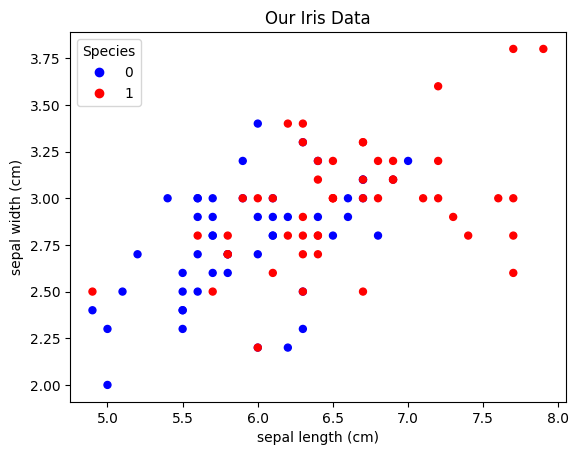

In [4]:
# Scatterplot example
s = plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,s=25, cmap='bwr')
plt.legend(*s.legend_elements(),title='Species') # adds scatterplot to legend
plt.title('Our Iris Data')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.show()

# Step 2 - Preprocessing

In the future we will set up neat pipelines to scale and transform the data.  For now our only job here is to do the test/train split.

## Test/Train Split
To meet our goal of making the "best" classifier we have to answer two closely related questions:
1.  How do we choose the best parameters to avoid under/over-fitting?
1.  How well will our classifier do with *new* samples?  

The answer to both is to split the dataset and save a fraction as our "test" data that we **DO NOT FIT THE CLASSIFIER** with.  

The concept of saving data where we know the right answer is our key to tuning parameters and estimating performance.  Data that has been used to train the classifier **cannot** be use to fairly evaluate a classifier. After all of the choices are made and everything is done, only then will we use the **TEST DATA** to estimate the final performance of the classifier on new data.

**NOTE:** In the future we will actually split the known data into 3 chunks: train, validation, and test.  The *validation* data is used to choose models and tune values of hyperparameters.  Then only at the very end, after our final model is chosen, will we evaluate it on the *test* data to estimate how will the model works.  Fancy tools like ```GridSearchCV``` will help automate this.


###Random State

Before we begin, it is important to understand how ```random_state``` works.  In a nutshell, there is no such thing as a random number in computing.  All random numbers are generated from a seed, and the same algorithm with the same seed produces the same list of numbers.  It is sometimes convenient to get set the seed with ```random_state``` to get the same results while you are working.  Common values are 0,1, 42, or other sci-fi / pop-culture references.  

A good analogy is to think about a book filled with numbers.  Setting random_state tells the program which page of the book to use.  

For more detail, read section 3 in https://scikit-learn.org/stable/common_pitfalls.html

**References**
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
* https://scikit-learn.org/stable/common_pitfalls.html#data-leakage


Train samples:	 75
Test samples:	 25


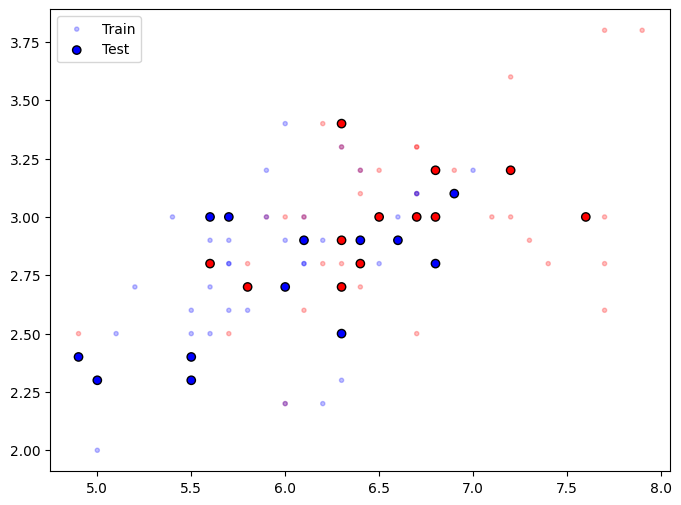

In [16]:
# Run this with and without random_state, try different values
#X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print('Train samples:\t', len(y_train))
print('Test samples:\t', len(y_test))

plt.figure(figsize=(8,6))
plt.scatter(X_train[:,0], X_train[:,1],marker='.',c=y_train,cmap='bwr',label='Train', alpha=0.25)
plt.scatter(X_test[:,0], X_test[:,1],marker='o',edgecolor='k',c=y_test,cmap='bwr',label='Test')
plt.legend()

plt.show()

# Step 3 - Training

The "learning" part of ML happens here as the model attempts to calculate the target from the features based on the training data.  

## Classifiers in sklearn
Before we dig in to see how classifiers **work**, I think it is very helpful to see how they are **used**.  The basic commands we need for a classifier *clf* are:
* ```clf.fit(X_train, y_train)```  : use training data to learn to reproduce the right targets from features.
* ```clf.predict(X)``` : classify samples in X to predict y  
* ```clf.score(X,y)``` : calls predict(X) and measures the accuracy against the right answers in y


We will use a ```KNeighborsClassifier``` that has one hyperparameter to adjust called ```n_neighbors```.  In this case a low value gives a more complex model while a high value gives a smoother, simpler model.

 **IMPORTANT:** DO NOT EVER, EVER, EVER USE ```FIT``` ON THE TEST DATA!

In [6]:
clf = KNeighborsClassifier(n_neighbors=40)
clf.fit(X_train, y_train)
print(f"Training Score:\t{clf.score(X_train,y_train):0.3f}")

Training Score:	0.733


That's it.  Our model learned how to calculate y_train given X_train and is able to get the right answer 73% of the time.

Of course, we could change the hyperparameter...

In [7]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
print(f"Training Score:\t{clf.score(X_train,y_train):0.3f}")

Training Score:	0.907


As expected, a more complex model can get a higher training score.  Is that better?

# Step 4 - Evaluating
After (and only **after**) the training is complete we will evaluate its performance and estimate how well it will work on new data where we **don't** know the right answer.  Later we will learn more methods for measuring performance instead of a simple accuracy percentage score.

As mentioned above, later on we will split the data into 3 chunks so we can use the *validation* set to tune a model and the *test* set it evaluate final performace.  We are keeping things simple today...

* UNDER-fitting: poor scores on both train and test (note that "poor" is relative...), model is too simple
* OVER-fitting: good score on train but poor score on train, model is too complex
* Fitting: should get similar good scores on both train and test, right balance of complexity

**CHECK:** try changing n_neighbors.  Can you find a good value?

In [8]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
print(f"Train:\t{clf.score(X_train,y_train):0.2f}")
print(f"Test:\t{clf.score(X_test,y_test):0.2f}")

Train:	0.91
Test:	0.64


# Step 5 - Predicting
We have a shiny new classifier, so let's use it!  Given a new flower with new measurements we can predict what the species is.  We can expect our accuracy to be approximately the same as the *test* score above.

To use ```predict(X)``` remember that the ```X``` must be a 2D with the same features as what the model was fitted to.

In [9]:
# What species is a flower with length=6 and width=7
y_pred = clf.predict([[6,7]])
print(y_pred)
print(target_names[y_pred])

[0]
['versicolor']


In [10]:
# Can do many samples at once
X_pred = np.random.randint(2,10, (5,2))
y_pred = clf.predict(X_pred)
print('Totally real flowers:')
print(X_pred)
print('\nSpecies are: ',y_pred)

Totally real flowers:
[[9 7]
 [8 7]
 [4 7]
 [8 4]
 [9 2]]

Species are:  [1 1 0 1 1]


## Decision Boundaries
Imagine taking the data plot from Step 1 and making a grid of thousands of possibilites for the features.  With brutal force we can call predict on each point and make a map called a **decision boundary**.

This is a useful crutch while we are learning to make machines learn.  Real problems typically have LOTS of features, sometimes millions.  The most we can directly plot is 2.  So we don't get to visualize most problems this way, it can be instructive. For the plot options see: https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html#sklearn.inspection.DecisionBoundaryDisplay.from_estimator

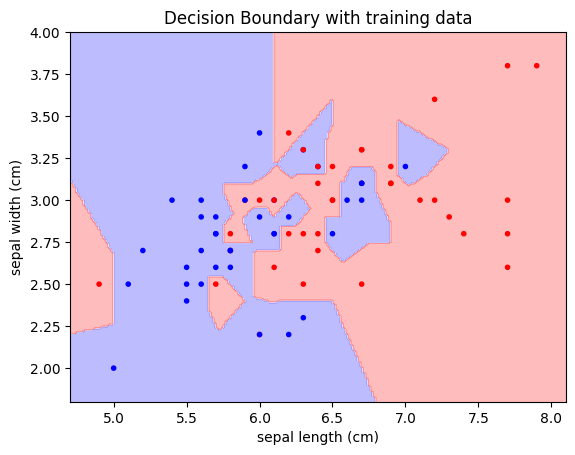

In [11]:
clf = KNeighborsClassifier(n_neighbors=1)  #defaults to 5 neighbors
clf.fit(X_train,y_train)

DecisionBoundaryDisplay.from_estimator(clf,X_train,grid_resolution=200, response_method='predict',eps=0.2, cmap='bwr', alpha=0.3)
plt.scatter(X_train[:,0], X_train[:,1],marker='.',c=y_train,cmap='bwr',label='Train', alpha=1)
plt.title('Decision Boundary with training data')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.show()


**CHECK:** see how different n_neighbors changes the decision boundary

If you want to see what was missed in test data we can draw them too

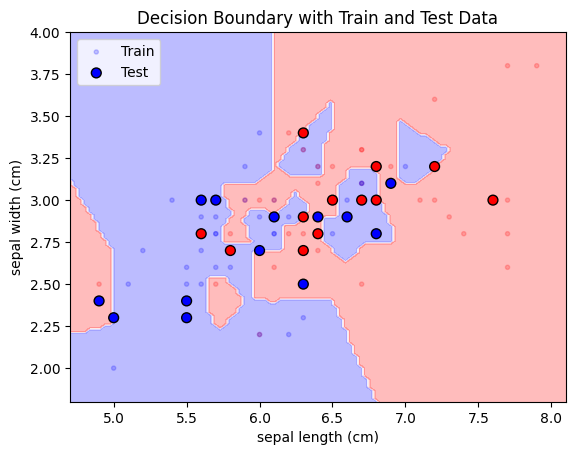

In [12]:
DecisionBoundaryDisplay.from_estimator(clf,X_train,grid_resolution=100, response_method='predict',eps=0.2, cmap='bwr', alpha=0.3)
plt.scatter(X_train[:,0], X_train[:,1],marker='.',c=y_train,cmap='bwr',label='Train', alpha=0.2)
plt.scatter(X_test[:,0], X_test[:,1],marker='o',s=50,edgecolor='k',c=y_test,cmap='bwr',label='Test')
plt.title('Decision Boundary with Train and Test Data')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()
plt.show()


# Summary
We built up some simplified but usable infrastructure for doing basic machine learning.  Make sure you are comfortable with:
* test/train split and random_state
* Standard functions like fit, score, and predict
* Why we only call fit on train and NEVER ON TEST
* Drawing decision boundaries

We will need all of these tools (and more) while we explore how classifiers actually work.